#  Assignment: Handwritten digits dataset

The dataset that you will use in this assignment is the [*digits* dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) which contains $1797$ images of $10$ hand-written digits. The digits have been preprocessed so that $32 \times 32$ bitmaps are divided into non-overlapping blocks of $4 \times 4$ and the number of on pixels are counted in each block. This generates an input matrix of $8 \times 8$ where each element is an integer in the range of $[0, ..., 16]$. This reduces dimensionality and gives invariance to small distortions.

For further information on NIST preprocessing routines applied to this data, see M. D. Garris, J. L. Blue, G. T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C. L. Wilson, *NIST Form-Based Handprint Recognition System*, NISTIR 5469, 1994.

As before, use the `sklearn`'s data uploading routines to load the dataset and get the data fields.

**Task:** For the rest of the practical, apply the data preprocessing techniques, implement and evaluate the classification models on the digits dataset using the steps that you applied above to the iris dataset.

In [0]:
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Uploading the dataset

In [0]:
# Uploading the dataset

from sklearn import datasets
digits = datasets.load_digits()
print(list(digits.keys()))
print(digits.target_names)

['data', 'target', 'target_names', 'images', 'DESCR']
[0 1 2 3 4 5 6 7 8 9]


In [0]:
X, y = digits["data"], digits["target"]
X.shape

(1797, 64)

In [0]:
y.shape

(1797,)

Label: 3


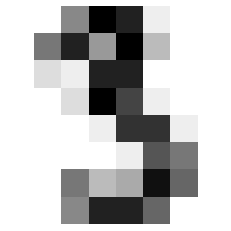

In [0]:
some_digit = X[3]
print("Label: {}".format(y[3]))
some_digit_image = some_digit.reshape(8, 8)

plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [0]:
np.random.seed(1)

Looking at which pixels are the most important for each digit by computing the average value at that pixel across all the images.

An example for digit 3:


In [0]:
np.random.seed(1)
ix_3 = np.where(digits["target"] == 3)
X_3 = X[ix_3]
X_3.shape

(183, 64)

In [0]:
# Average value per pixel
X_3_avg = np.sum(X_3, axis=0) / X_3.shape[0]
X_3_avg.shape

(64,)

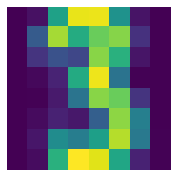

In [0]:
fig = plt.figure(figsize=(3,3))
plt.imshow(X_3_avg.reshape((8, 8)))
plt.axis('off')
plt.show()

Now for all digits

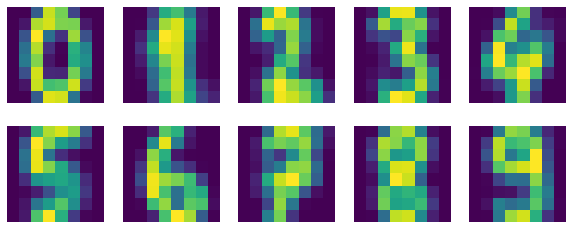

In [0]:
fig=plt.figure(figsize=(10, 4))

index = 1
columns = 5
rows = 2

for i in range(1, 11):
    X_i = X[np.where(digits['target'] == i-1)]
    X_i_avg = np.average(X_i, axis=0)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(X_i_avg.reshape((8,8)))


plt.show()

Difference between the given digit and the all the other digits combined, i.e. which parts of the image for a specific digit are extra important compared to all the other images. For example, 0 is special because, unlike other images, it has a hole in the middle so the middle of the image has higher-valued (lighter) pixels relative to the other digits.

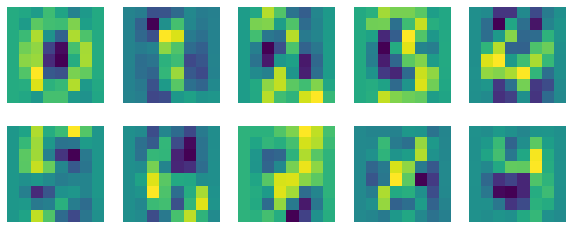

In [0]:
fig=plt.figure(figsize=(10, 4))

index = 1
columns = 5
rows = 2

for i in range(1, 11):
    X_i = X[np.where(digits['target'] == i-1)]
    X_i_avg = np.average(X_i, axis=0)
    X_i_diff = X_i_avg - np.average(X[np.where(digits['target'] != i-1)], axis=0)
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(X_i_diff.reshape((8,8)))


plt.show()

## Splitting the data into training and test subsets

Apply stratified random splitting by digit so that each digit is equally represented in train and test sets.

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
split.get_n_splits(X, y)
print(split)       

for train_index, test_index in split.split(X, y):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

StratifiedShuffleSplit(n_splits=1, random_state=2, test_size=0.2,
            train_size=None)
TRAIN: 1437 TEST: 360
(1437, 64) (1437,) (360, 64) (360,)


This returns the following proportions of each digit.

In [0]:
import pandas as pd

def subset_proportions(subset):
    props = {}
    for value in set(subset):
        data_value = [i for i in subset if i==value]
        props[value] = len(data_value) / len(subset)
    return props

   
compare_props = pd.DataFrame({
    "Overall": subset_proportions(digits["target"]),
    "Stratified tr": subset_proportions(y_train),
    "Stratified ts": subset_proportions(y_test),
})
compare_props["Strat. tr %error"] = 100 * compare_props["Stratified tr"] / compare_props["Overall"] - 100
compare_props["Strat. ts %error"] = 100 * compare_props["Stratified ts"] / compare_props["Overall"] - 100

compare_props.sort_index()

,Overall,Stratified tr,Stratified ts,Strat. tr %error,Strat. ts %error
0,0.099054,0.098817,0.100000,-0.239263,0.955056
1,0.101280,0.101601,0.100000,0.316594,-1.263736
2,0.098497,0.098817,0.097222,0.324357,-1.294727
3,0.101836,0.101601,0.102778,-0.231584,0.924408
4,0.100723,0.100905,0.100000,0.179933,-0.718232
5,0.101280,0.100905,0.102778,-0.370506,1.478938
6,0.100723,0.100905,0.100000,0.179933,-0.718232
7,0.099610,0.099513,0.100000,-0.097969,0.391061
8,0.096828,0.096729,0.097222,-0.101984,0.407088
9,0.100167,0.100209,0.100000,0.041754,-0.166667


## Binary classification

### Perceptron

Creating 10 perceptrons for the 10 classes of digits.

In [0]:
# Create binary labels to separate each digit
y_train_digit = [y_train == i for i in digits.target_names]
y_test_digit = [y_test == i for i in digits.target_names]
y_train_digit

[array([False, False, False, ..., False, False, False]),
 array([False, False, False, ...,  True, False,  True]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([ True, False,  True, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False,  True, False, ..., False,  True, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False]),
 array([False, False, False, ..., False, False, False])]

In [0]:
# Fit each digit's perceptron
from sklearn.linear_model import SGDClassifier

sgds = []
for i in digits.target_names:
  sgd = SGDClassifier(max_iter=5, tol=None, random_state=42,
                   loss="perceptron", eta0=1, learning_rate="constant", penalty=None)
  sgd.fit(X_train, y_train_digit[i])
  sgds.append(sgd)

### Logistic regression

In [0]:
from sklearn.linear_model import LogisticRegression

log_regs = []
for i in digits.target_names:
  log_reg = LogisticRegression()
  log_reg.fit(X_train, y_train_digit[i])
  log_regs.append(log_reg)

### Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

gnbs = []
for i in digits.target_names:
  gnb = GaussianNB() 
  gnb.fit(X_train, y_train_digit[i])
  gnbs.append(gnb)

## Evaluation

In [0]:
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

log_reg_scores = []
gnb_scores = []
sgd_scores = []

for i in digits.target_names:
  print(i)
  log_reg_score = cross_val_score(log_regs[i], X_train, y_train_digit[i], cv=5, scoring="accuracy")
  gnb_score = cross_val_score(gnbs[i], X_train, y_train_digit[i], cv=5, scoring="accuracy")
  sgd_score = cross_val_score(sgds[i], X_train, y_train_digit[i], cv=5, scoring="accuracy")
  log_reg_scores.append(log_reg_score)
  gnb_scores.append(gnb_score)
  sgd_scores.append(sgd_score)
  print(log_reg_score)
  print(gnb_score)
  print(sgd_score)
  print()

0
[1.         1.         1.         0.99303136 1.        ]
[0.99652778 0.99305556 0.97909408 0.97909408 0.98954704]
[1.         0.99652778 1.         0.99303136 0.99651568]

1
[0.96539792 0.95470383 0.98954704 0.97212544 0.96864111]
[0.69896194 0.72125436 0.47735192 0.65853659 0.55400697]
[0.94463668 0.95121951 0.98954704 0.94773519 0.96515679]

2
[1.         1.         1.         0.99651568 1.        ]
[0.73958333 0.74305556 0.66898955 0.76655052 0.70731707]
[0.99652778 1.         1.         0.9825784  0.99651568]

3
[0.98961938 0.98954704 0.9825784  0.98606272 0.9825784 ]
[0.66089965 0.68989547 0.71428571 0.728223   0.75261324]
[0.98269896 0.98954704 0.97560976 0.97560976 0.96515679]

4
[0.99652778 0.99652778 1.         1.         0.99303136]
[0.86458333 0.82638889 0.85714286 0.81533101 0.90940767]
[0.99305556 0.98958333 0.98954704 0.99303136 0.98954704]

5
[0.99305556 0.97916667 0.99651568 0.98606272 0.98606272]
[0.62152778 0.69097222 0.58188153 0.68292683 0.66202091]
[0.98263889 0.

### Baselines

In [0]:
from sklearn.base import BaseEstimator

class NotXClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

not_digit_clf = NotXClassifier()
not_digit_clf_scores = []
for i in digits.target_names:
  score = cross_val_score(not_digit_clf, X_train, y_train_digit[i], cv=5, scoring="accuracy")
  print(score)
  not_digit_clf_scores.append(score)

[0.89930556 0.85763889 0.91637631 0.91289199 0.91986063]
[0.87847222 0.91319444 0.90243902 0.89547038 0.90243902]
[0.92013889 0.92361111 0.90243902 0.87108014 0.88850174]
[0.86805556 0.89930556 0.93031359 0.91986063 0.87456446]
[0.92013889 0.88194444 0.90940767 0.87108014 0.91289199]
[0.90625    0.90277778 0.8815331  0.90940767 0.89547038]
[0.89583333 0.92361111 0.8815331  0.90243902 0.89198606]
[0.88541667 0.92361111 0.90592334 0.87804878 0.90940767]
[0.90277778 0.89930556 0.89198606 0.91986063 0.90243902]
[0.92361111 0.875      0.87804878 0.91986063 0.90243902]


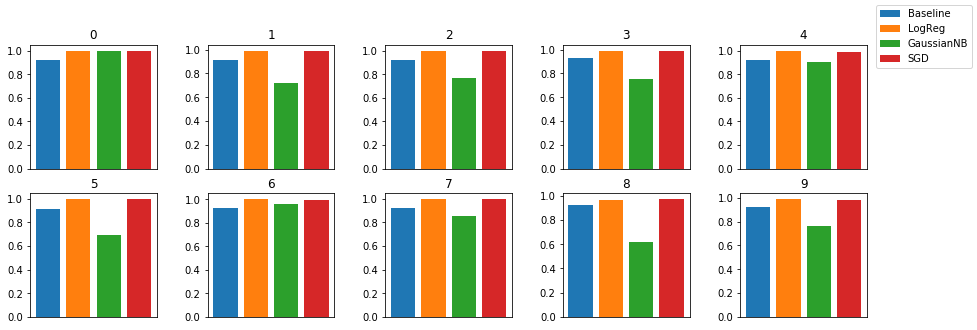

In [0]:
fig=plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

index = 1
columns = 5
rows = 2

for i in range(1, 11):
  ax = fig.add_subplot(rows, columns, i)
  index += 1
  ax.bar(0, not_digit_clf_scores[i-1])
  ax.bar(1, log_reg_scores[i-1])
  ax.bar(2, gnb_scores[i-1])
  ax.bar(3, sgd_scores[i-1])
  ax.title.set_text(i-1)
  ax.tick_params(axis='x', bottom=False, labelbottom=False)
    
fig.legend(('Baseline', 'LogReg', 'GaussianNB', 'SGD'))
plt.show()

### Confusion matrices

#### Logistic regression

[[1294    1]
 [   1  141]]
[[1261   30]
 [  13  133]]
[[1294    1]
 [   0  142]]
[[1280   11]
 [   9  137]]
[[1292    0]
 [   4  141]]
[[1283    9]
 [   8  137]]
[[1289    3]
 [   5  140]]
[[1291    3]
 [   4  139]]
[[1261   37]
 [  37  102]]
[[1276   17]
 [  16  128]]


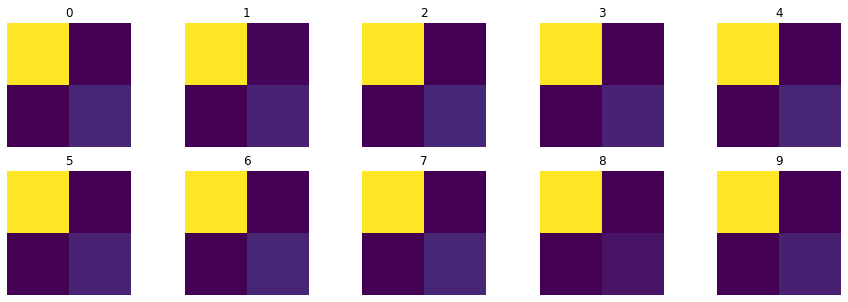

In [0]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

fig=plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

index = 1
columns = 5
rows = 2


for i in range(1, 11):
  y_train_pred = cross_val_predict(log_regs[i-1], X_train, y_train_digit[i-1], cv=5)
  fig.add_subplot(rows, columns, i)
  print(confusion_matrix(y_train_digit[i-1], y_train_pred))
  plt.axis('off')
  plt.title(i-1)
  plt.imshow(confusion_matrix(y_train_digit[i-1], y_train_pred))
  index += 1


plt.show()

### Precision/Recall

#### Logistic regression

In [0]:
from sklearn.metrics import precision_score, recall_score, f1_score

for i in digits.target_names:
  print(i)
  y_train_pred = cross_val_predict(log_regs[i], X_train, y_train_digit[i], cv=5)
  print(precision_score(y_train_digit[i], y_train_pred), 
        recall_score(y_train_digit[i], y_train_pred),
        f1_score(y_train_digit[i], y_train_pred))
  print()

0
0.9929577464788732 0.9929577464788732 0.9929577464788732

1
0.8159509202453987 0.910958904109589 0.8608414239482199

2
0.993006993006993 1.0 0.9964912280701755

3
0.9256756756756757 0.9383561643835616 0.9319727891156463

4
1.0 0.9724137931034482 0.9860139860139859

5
0.9383561643835616 0.9448275862068966 0.9415807560137458

6
0.9790209790209791 0.9655172413793104 0.9722222222222222

7
0.9788732394366197 0.972027972027972 0.9754385964912281

8
0.7338129496402878 0.7338129496402878 0.7338129496402878

9
0.8827586206896552 0.8888888888888888 0.8858131487889273



We could compare this to the approach with Gaussian Naive Bayes which has the lowest scores.

### Gaussian Naive Bayes

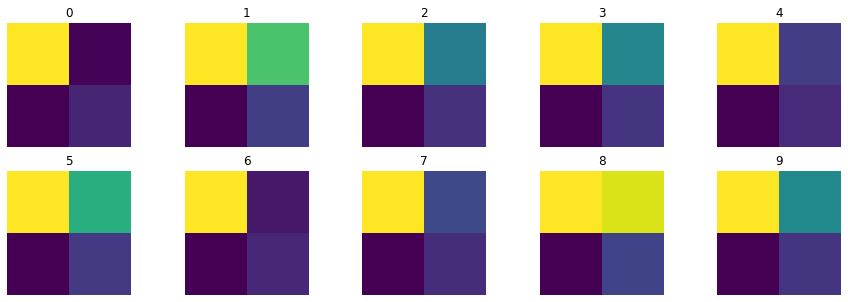

In [0]:
fig=plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.4)

index = 1
columns = 5
rows = 2


for i in range(1, 11):
  y_train_pred = cross_val_predict(gnbs[i-1], X_train, y_train_digit[i-1], cv=5)
  fig.add_subplot(rows, columns, i)
  plt.axis('off')
  plt.title(i-1)
  plt.imshow(confusion_matrix(y_train_digit[i-1], y_train_pred))
  index += 1

plt.show()

The confusion visibly reveals the much higher instances of misclassifications compared to the logistic regression approach. For example, digit 5 has more false positives (green) than true positives (blue), indicating that Gaussian Naive Bayes is more likely to say that the digit is 5 when it is not.

In [0]:
for i in digits.target_names:
  print(i)
  y_train_pred = cross_val_predict(gnbs[i], X_train, y_train_digit[i], cv=5)
  print(precision_score(y_train_digit[i], y_train_pred), 
        recall_score(y_train_digit[i], y_train_pred),
        f1_score(y_train_digit[i], y_train_pred))
  print()

0
0.9078947368421053 0.971830985915493 0.9387755102040817

1
0.20851688693098386 0.9726027397260274 0.34340991535671106

2
0.259047619047619 0.9577464788732394 0.40779610194902544

3
0.25272727272727274 0.952054794520548 0.3994252873563219

4
0.4064327485380117 0.9586206896551724 0.5708418891170431

5
0.21752738654147105 0.9586206896551724 0.3545918367346939

6
0.6470588235294118 0.9862068965517241 0.7814207650273225

7
0.375 0.986013986013986 0.5433526011560694

8
0.17754569190600522 0.9784172661870504 0.30055248618784525

9
0.24684684684684685 0.9513888888888888 0.39198855507868385



In general, Gaussian Naive Bayes seems to have a much higher *false positive rate* (hence lower *specificity*), which could be seen from comparing the ROC-AUC curves of the two types of classifiers.

### ROC curves

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1.01])
    plt.xlabel("False positive rate (fpr)")
    plt.ylabel("True positive rate (tpr)")

0
0.9999836858991789 0.9594866496274947
1
0.9873995946648557 0.8700805364854682
2
1.0 0.8746750774919789
3
0.9951773606527805 0.8847580191632269
4
0.9999359453400235 0.9679646631792463
5
0.995601580014946 0.875589836660617
6
0.9980623465357105 0.976788192591011
7
0.9987138055144238 0.9248575998962397
8
0.974265887752048 0.789241334205363
9
0.9879694079230043 0.8849359800635903


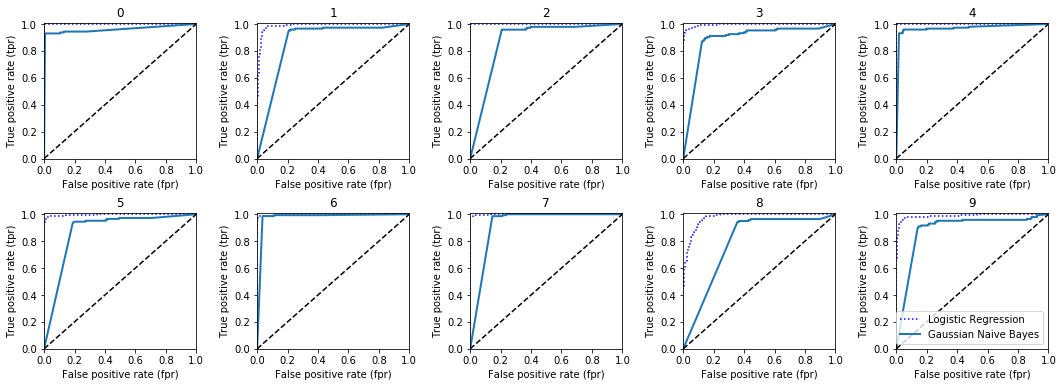

In [0]:
fig=plt.figure(figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

index = 1
columns = 5
rows = 2


for i in range(1, 11):
  y_probas_gnb = cross_val_predict(gnbs[i-1], X_train, y_train_digit[i-1], cv=3, method="predict_proba")
  y_probas_log_reg = cross_val_predict(log_regs[i-1], X_train, y_train_digit[i-1], cv=3, method="predict_proba")

  y_scores_gnb = y_probas_gnb[:, 1] # score = proba of the positive class
  y_scores_log_reg = y_probas_log_reg[:, 1]

  fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_train_digit[i-1], y_scores_gnb)
  fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(y_train_digit[i-1], y_scores_log_reg)
  print(i-1)
  print(roc_auc_score(y_train_digit[i-1], y_scores_log_reg), roc_auc_score(y_train_digit[i-1], y_scores_gnb))
  
  fig.add_subplot(rows, columns, i)
  plt.plot(fpr_log_reg, tpr_log_reg, "b:", label="Logistic Regression")
  plot_roc_curve(fpr_gnb, tpr_gnb, "Gaussian Naive Bayes")

  plt.title(i-1)
  index += 1

plt.legend(loc="lower right")
plt.show()

The above ROC curves show that both types of classifiers have similar performance in detecting digits like 0, 4 and 6, and Gaussian Naive Bayes has relatively low performance compared to the logistic regression in digits like 5 and 8—corresponding to discrepancies in the confusion matrix.

Logistic regression seems to have perfect area under curve for digit 2.

### Kernel trick

In [0]:
from sklearn.kernel_approximation import RBFSampler

gnb_rbfs = []
rbf_features = RBFSampler(gamma=1, random_state=42)
X_train_features = rbf_features.fit_transform(X_train)
print(X_train.shape, "->", X_train_features.shape)

for i in digits.target_names:
  gnb_rbf = GaussianNB()
  gnb_rbf.fit(X_train_features, y_train_digit[i]) 
  print(gnb_rbf.score(X_train_features, y_train_digit[i]))
  gnb_rbfs.append(gnb_rbf)

(1437, 64) -> (1437, 100)
0.9018789144050104
0.9004871259568545
0.9025748086290883
0.8997912317327766
0.9004871259568545
0.8983994432846207
0.8990953375086986
0.8997912317327766
0.9046624913013221
0.9011830201809325


Comparing the ROC curves for standard and kernel-transformed Gaussian Naive Bayes,

0
0.9594866496274947 0.3750720539452934
1
0.8700805364854682 0.4633606740023132
2
0.8746750774919789 0.33709554625047583
3
0.8847580191632269 0.8274407648313402
4
0.9679646631792463 0.1696140706736415
5
0.875589836660617 0.6164460339489698
6
0.976788192591011 0.2318138144550016
7
0.9248575998962397 0.5400908982825521
8
0.789241334205363 0.5518146345789317
9
0.8849359800635903 0.8849359800635903


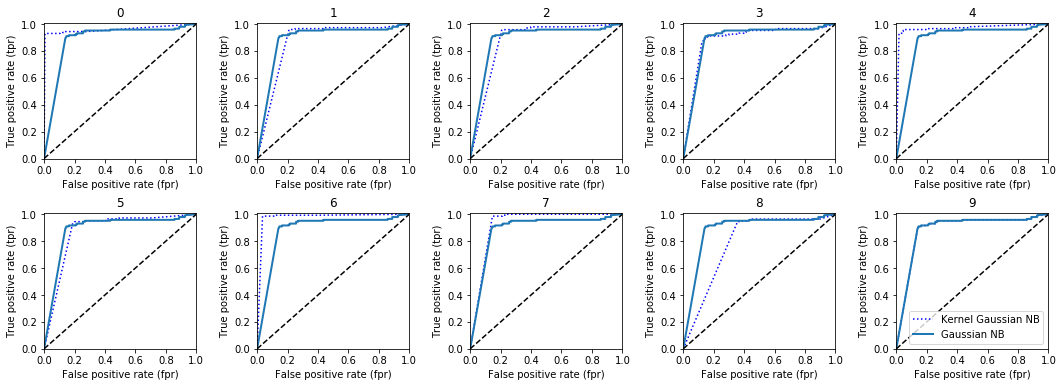

In [0]:
fig=plt.figure(figsize=(18, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

index = 1
columns = 5
rows = 2

from sklearn.metrics import roc_auc_score

for i in range(1, 11):
  y_probas_gnb_rbf = cross_val_predict(gnb_rbfs[i-1], X_train, y_train_digit[i-1], cv=3, method="predict_proba")
  y_scores_gnb_rbf = y_probas_gnb_rbf[:, 1]
  fpr_gnb_rbf, tpr_gnb_rbf, thresholds_gnb_rbf = roc_curve(y_train_digit[i-1], y_scores_gnb_rbf)
  print(i-1)
  print(roc_auc_score(y_train_digit[i-1], y_scores_gnb_rbf), roc_auc_score(y_train_digit[i-1], y_scores_gnb))
  
  fig.add_subplot(rows, columns, i)
  plt.plot(fpr_gnb_rbf, tpr_gnb_rbf, "b:", label="Kernel Gaussian NB")
  plot_roc_curve(fpr_gnb, tpr_gnb, "Gaussian NB")

  plt.title(i-1)
  index += 1

plt.legend()
plt.show()

It seems like performance is varied and depends on the digit, e.g. improved for 0, 4 and 6 (where it was already relatively good) but got even worse for digit 8 (which had already relatively bad performance).

## Multi-class Classification

In [0]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.kernel_approximation import RBFSampler

# One vs All SGD Classifier
sgd = SGDClassifier(max_iter=5, random_state=42, loss="perceptron", 
                                           eta0=1, learning_rate="constant", penalty=None)
sgd.fit(X_train, y_train)

# One vs All Gaussian NB Classifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# One vs One SGD Classifier
rbf_features = RBFSampler(gamma=1, n_components=100, random_state=42)
X_train_features = rbf_features.fit_transform(X_train)

ovo_sgd = OneVsOneClassifier(SGDClassifier(max_iter=5, random_state=42, loss="perceptron", 
                                           eta0=1, learning_rate="constant", penalty=None))
ovo_sgd.fit(X_train, y_train)

# One vs One Gaussian NB Classifier
ovo_gnb = OneVsOneClassifier(GaussianNB())
ovo_gnb.fit(X_train, y_train)


OneVsOneClassifier(estimator=GaussianNB(priors=None, var_smoothing=1e-09),
                   n_jobs=None)

Looking at untransformed performance first,

In [0]:
print(cross_val_score(sgd, X_train, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(gnb, X_train, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(ovo_sgd, X_train, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(ovo_gnb, X_train, y_train, cv=5, scoring="accuracy"))

[0.87628866 0.95155709 0.95121951 0.95804196 0.88380282]
[0.82130584 0.85813149 0.88501742 0.84965035 0.83098592]
[0.97938144 0.95155709 0.95818815 0.94405594 0.92957746]
[0.82130584 0.85813149 0.88501742 0.84965035 0.83098592]




Now with applied transformations,

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

print(cross_val_score(sgd, X_train_features, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(gnb, X_train_features, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(ovo_sgd, X_train_features, y_train, cv=5, scoring="accuracy"))
print(cross_val_score(ovo_gnb, X_train_features, y_train, cv=5, scoring="accuracy"))

[0.11340206 0.10726644 0.10452962 0.0979021  0.0915493 ]
[0.11683849 0.12110727 0.11149826 0.08741259 0.09859155]
[0.12714777 0.07958478 0.08710801 0.1013986  0.09859155]
[0.11683849 0.12110727 0.11149826 0.08741259 0.09859155]


Now the performance is very poor for all classifiers. This can be further visualised with the confusion matrix:

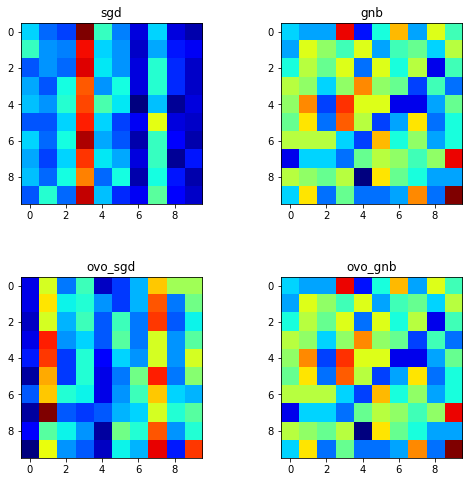

In [0]:
y_train_pred_sgd = cross_val_predict(sgd, X_train_features, y_train, cv=3)
y_train_pred_gnb = cross_val_predict(gnb, X_train_features, y_train, cv=3)

y_train_pred_ovo_sgd = cross_val_predict(ovo_sgd, X_train_features, y_train, cv=3)
y_train_pred_ovo_gnb = cross_val_predict(ovo_gnb, X_train_features, y_train, cv=3)


conf_mxs = [confusion_matrix(y_train, y_train_pred_sgd),
            confusion_matrix(y_train, y_train_pred_gnb),
            confusion_matrix(y_train, y_train_pred_ovo_sgd),
            confusion_matrix(y_train, y_train_pred_ovo_gnb)]
conf_mxs_labels = ['sgd', 'gnb', 'ovo_sgd', 'ovo_gnb']

fig=plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

index = 0
columns = 2
rows = 2

for i in range(1, columns*rows+1):
  fig.add_subplot(rows, columns, i)
  plt.imshow(conf_mxs[index], cmap = "jet")
  plt.title(conf_mxs_labels[index])
  index += 1

plt.show()

Looks like the classifiers are pretty confused. :/ 

On the untransformed data,

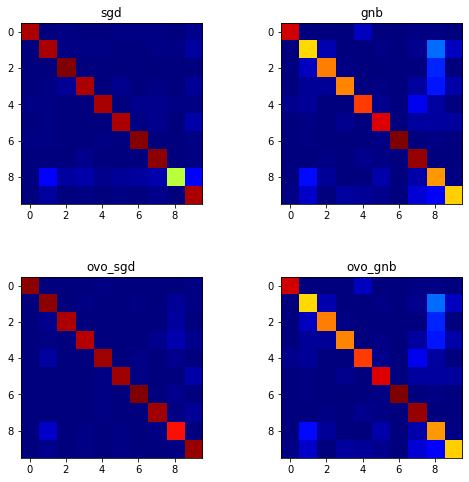

In [0]:
y_train_pred_sgd = cross_val_predict(sgd, X_train, y_train, cv=3)
y_train_pred_gnb = cross_val_predict(gnb, X_train, y_train, cv=3)

y_train_pred_ovo_sgd = cross_val_predict(ovo_sgd, X_train, y_train, cv=3)
y_train_pred_ovo_gnb = cross_val_predict(ovo_gnb, X_train, y_train, cv=3)


conf_mxs = [confusion_matrix(y_train, y_train_pred_sgd),
            confusion_matrix(y_train, y_train_pred_gnb),
            confusion_matrix(y_train, y_train_pred_ovo_sgd),
            confusion_matrix(y_train, y_train_pred_ovo_gnb)]
conf_mxs_labels = ['sgd', 'gnb', 'ovo_sgd', 'ovo_gnb']

fig=plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

index = 0
columns = 2
rows = 2

for i in range(1, columns*rows+1):
  fig.add_subplot(rows, columns, i)
  plt.imshow(conf_mxs[index], cmap = "jet")
  plt.title(conf_mxs_labels[index])
  index += 1

plt.show()

So in the digits dataset we got the better performance when not transforming the features with the `RBFSampler`.

Further scaling untransformed data,

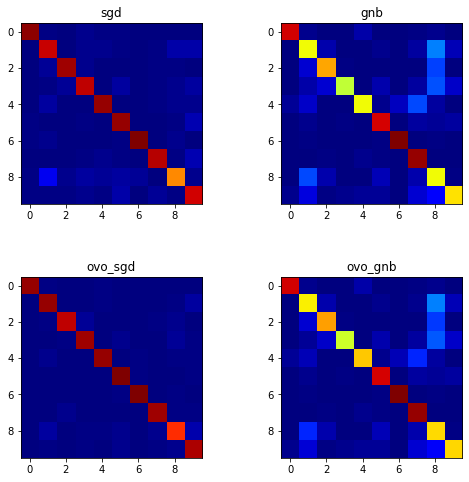

In [0]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

y_train_pred_sgd = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
y_train_pred_gnb = cross_val_predict(gnb, X_train_scaled, y_train, cv=3)

y_train_pred_ovo_sgd = cross_val_predict(ovo_sgd, X_train_scaled, y_train, cv=3)
y_train_pred_ovo_gnb = cross_val_predict(ovo_gnb, X_train_scaled, y_train, cv=3)


conf_mxs = [confusion_matrix(y_train, y_train_pred_sgd),
            confusion_matrix(y_train, y_train_pred_gnb),
            confusion_matrix(y_train, y_train_pred_ovo_sgd),
            confusion_matrix(y_train, y_train_pred_ovo_gnb)]
conf_mxs_labels = ['sgd', 'gnb', 'ovo_sgd', 'ovo_gnb']

fig=plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

index = 0
columns = 2
rows = 2

for i in range(1, columns*rows+1):
  fig.add_subplot(rows, columns, i)
  plt.imshow(conf_mxs[index], cmap = "jet")
  plt.title(conf_mxs_labels[index])
  index += 1

plt.show()

The performance seems to be slightly worse as the values in diagonal take lower values.

In [0]:
import sklearn
print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)

0.21.3
1.17.3
0.25.3
